In [4]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

In [5]:
batch_size = 8
evaluate = False
backbone = 'mobilenet_v2'

hyper_params = train_utils.get_hyper_params(backbone)
test_data, size_info = data_utils.get_dataset("test", dir_ = "F:\Minor Data Collection\Final Image Data\Monument Original\TFRecord\\")
total_items = size_info

In [6]:
labels = label_generator.csv_to_label_map("helper\Report\ps-up-sp-BDS-alamy-merged.csv", 'list-type')
labels = ["bg"] + labels
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [7]:
from models import header
ssd_mobilenet_model = tf.keras.models.load_model("MobileNetV2_SSD_SavedModel", custom_objects={
    "HeadWrapper": header.HeadWrapper
})

In [8]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_mobilenet_model.predict(test_data, steps=step_size, verbose=1)

45/45 [==============================] - 21s 401ms/step


In [10]:
test_data, size_info = data_utils.get_dataset("test", dir_ = "F:\Minor Data Collection\Final Image Data\Monument Original\TFRecord\\")
test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [11]:
def IOU_score(pred_bbox, gt_bbox, width = 300, height = 300):
    p_y1, p_x1, p_y2, p_x2 = pred_bbox
    gt_y1, gt_x1, gt_y2, gt_x2 = gt_bbox

    p_y1, p_x1, p_y2, p_x2 = int(p_y1 * height), int(p_x1 * width), int(p_y2 * height), int(p_x2 * width)
    gt_y1, gt_x1, gt_y2, gt_x2 = int(gt_y1 * height), int(gt_x1 * width), int(gt_y2 * height), int(gt_x2 * width)
    
    area_pbox = (p_x2 - p_x1) * (p_y2 - p_y1)
    area_gtbox = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    xx = max(p_x1, gt_x1)
    yy = max(p_y1, gt_y1)
    aa = min(p_x2, gt_x2)
    bb = min(p_y2, gt_y2)

    w = max(0, aa - xx)
    h = max(0, bb - yy)

    intersection_area = w * h

    if intersection_area == 0:
        return None
    union_area = area_pbox + area_gtbox - intersection_area
    return float(intersection_area) / float(union_area)

In [164]:
gt_ROIs = 0
image_no = 0
iou_threshold = 0.5
data_list = []
for index, ele in enumerate(test_data):
    gt_ind_ROI = 0
    image_name = 'Image' + str(image_no)
    bounding_boxes = ele[1].numpy()
    class_labels = ele[2].numpy()
    
    predicted_pred_bboxes = pred_bboxes[index]
    pred_class_labels = pred_labels[index]
    pred_conf_scores = pred_scores[index]
    
    for _ in class_labels:
        gt_ind_ROI += 1
    gt_ROIs += gt_ind_ROI  
    
    detected_count = 0
    for bbox in predicted_pred_bboxes:
        if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
            detected_count += 1
        else:
            break
    
    # Caculating TP, FP, TN
    
    for i in range(detected_count):
        tp = 0
        fp = 0
        tn = 0
        
        # calculating TP and FP
#         if pred_class_labels[i] in class_labels:
#             class_label_index = class_labels.tolist().index(pred_class_labels[i])
#             if IOU_score(predicted_pred_bboxes[i], bounding_boxes[class_label_index]) > iou_threshold:
#                 tp = 1
#             else:
#                 fp = 1 
#         else:
#             fp = 1

        for j, bbox in enumerate(bounding_boxes):
            if IOU_score(predicted_pred_bboxes[i], bbox) > 0.5:
                if pred_class_labels[i] == class_labels[j]:
                    tp = 1
                else:
                    fp = 1
                break
            
        # Calculate TN
#         for j in range(detected_count):
#             if j != i:
#                 if pred_class_labels[j] in class_labels:
#                     class_label_index = class_labels.tolist().index(pred_class_labels[j])
#                     if IOU_score(predicted_pred_bboxes[j], bounding_boxes[class_label_index]) > iou_threshold:
#                         tn += 1

        for j in range(detected_count):
            if j != i:

                for k, bbox_ in enumerate(bounding_boxes):
                    if IOU_score(predicted_pred_bboxes[j], bbox_) > iou_threshold:
                        tn += 1
                        
        data_list.append((image_name, labels[int(pred_class_labels[i])], pred_conf_scores[i] * 100, tp, fp, tn))
    
    image_no += 1

column_name = ['Image', 'Detection', 'Confidence', 'TP', 'FP', 'TN']    
df = pd.DataFrame(data_list, columns = column_name)
df.sort_values(['Confidence'], inplace = True, ignore_index = True, ascending = False)
df.head(20)

new_data_list = list()
accumulated_TP = 0
accumulated_FP = 0
accumulated_TN = 0

for row in df.iterrows():
    accumulated_TP += row[1]['TP']
    accumulated_FP += row[1]['FP']
    accumulated_TN += row[1]['TN']
    
    recall = float(accumulated_TP) / gt_ROIs
    specificity = float(accumulated_TN) / (float(accumulated_TN) + float(accumulated_FP))
    FPR = 1 - specificity
    
    new_data_list.append((row[1]['Image'], row[1]['Detection'], row[1]['Confidence'], row[1]['TP'], row[1]['FP'], row[1]['TN'], accumulated_TP, accumulated_FP, accumulated_TN, recall, specificity, FPR))

column_name = ['Image', 'Detection', 'Confidence', "TP", "FP", 'TN', 'Acc TP', 'Acc FP', 'Acc TN', 'Recall', 'Specificity', 'FPR']
new_df = pd.DataFrame(new_data_list, columns = column_name)
    

    

In [165]:
new_df

,Image,Detection,Confidence,TP,FP,TN,Acc TP,Acc FP,Acc TN,Recall,Specificity,FPR
0,Image252,nyatapola temple,100.000000,1,0,4,1,0,4,0.001645,1.000000,0.000000
1,Image255,chayasilin mandap,100.000000,1,0,4,2,0,8,0.003289,1.000000,0.000000
2,Image69,bhimeleshvara,100.000000,1,0,2,3,0,10,0.004934,1.000000,0.000000
3,Image324,shveta bhairava,100.000000,1,0,2,4,0,12,0.006579,1.000000,0.000000
4,Image33,nyatapola temple,100.000000,1,0,5,5,0,17,0.008224,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
599,Image265,kasthamandap,70.958126,0,1,1,471,58,902,0.774671,0.939583,0.060417
600,Image26,shveta bhairava,70.552891,0,0,1,471,58,903,0.774671,0.939646,0.060354
601,Image305,lalitpur tower,70.518631,0,1,2,471,59,905,0.774671,0.938797,0.061203
602,Image287,gopinath krishna temple,70.459443,0,1,1,471,60,906,0.774671,0.937888,0.062112


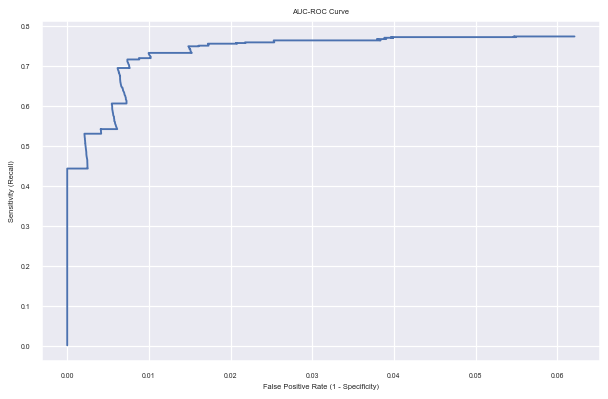

In [166]:
plt.figure(figsize = (8, 5), dpi = 90)
plt.plot(new_df['FPR'], new_df['Recall'])
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity (Recall)')
plt.show()

In [167]:
new_df['FPR']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
599    0.060417
600    0.060354
601    0.061203
602    0.062112
603    0.062112
Name: FPR, Length: 604, dtype: float64

In [168]:
from sklearn.metrics import auc

In [169]:
compare_list = np.arange(0.00, 0.20, 0.0022).tolist()
print(compare_list)

[0.0, 0.0022, 0.0044, 0.0066, 0.0088, 0.011000000000000001, 0.0132, 0.0154, 0.0176, 0.0198, 0.022000000000000002, 0.024200000000000003, 0.0264, 0.0286, 0.0308, 0.033, 0.0352, 0.0374, 0.0396, 0.041800000000000004, 0.044000000000000004, 0.046200000000000005, 0.048400000000000006, 0.050600000000000006, 0.0528, 0.055, 0.0572, 0.0594, 0.0616, 0.06380000000000001, 0.066, 0.06820000000000001, 0.0704, 0.0726, 0.0748, 0.077, 0.0792, 0.0814, 0.08360000000000001, 0.0858, 0.08800000000000001, 0.0902, 0.09240000000000001, 0.0946, 0.09680000000000001, 0.099, 0.10120000000000001, 0.1034, 0.1056, 0.1078, 0.11, 0.11220000000000001, 0.1144, 0.11660000000000001, 0.1188, 0.12100000000000001, 0.1232, 0.1254, 0.12760000000000002, 0.1298, 0.132, 0.1342, 0.13640000000000002, 0.1386, 0.1408, 0.14300000000000002, 0.1452, 0.1474, 0.1496, 0.15180000000000002, 0.154, 0.1562, 0.1584, 0.16060000000000002, 0.1628, 0.165, 0.16720000000000002, 0.16940000000000002, 0.1716, 0.1738, 0.17600000000000002, 0.1782, 0.1804, 0.

In [170]:
curr_ind = 0
recall_list = list()
fpr_list = list()

for ind, fpr in enumerate(new_df['FPR']):
    if fpr >= compare_list[curr_ind]:
        fpr_list.append(fpr)
        recall_list.append(new_df['Recall'].tolist()[ind])
        curr_ind += 1

Area under the Curve - ROC:  0.044676165403199686


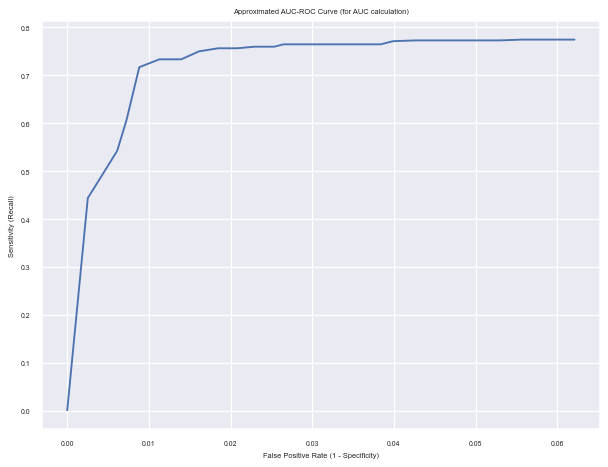

In [171]:
print("Area under the Curve - ROC: ", auc(fpr_list, recall_list))

plt.figure(figsize = (8, 6), dpi = 90)
plt.plot(fpr_list, recall_list)

plt.title("Approximated AUC-ROC Curve (for AUC calculation)")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity (Recall)')
plt.show()
